In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import requests

raw_url = "https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt"

response = requests.get(raw_url)
with open("names.txt", "w") as f:
    f.write(response.text)

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
import string

chars = sorted(list(string.ascii_lowercase))
chars.append('.')
print(chars)
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos[0] = '.'
print(itos)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
        # print()

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd = 10
n_hidden = 200
MANUAL_SEED = 2147483647
vocab_size = len(chars)
block_size = 3

g = torch.Generator().manual_seed(MANUAL_SEED)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(f"No. of parameters: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

No. of parameters: 12097


In [7]:
max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):
    # mini batch formation
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # fwd prop
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # back prop
    for p in parameters:
        p.grad = None
    loss.backward()

    # grad update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"Iteration {i}/{max_steps} : Loss = {loss.item():.4f}")
    loss_i.append(loss.log10().item())

    # break

Iteration 0/200000 : Loss = 3.3239
Iteration 10000/200000 : Loss = 2.0322
Iteration 20000/200000 : Loss = 2.5675
Iteration 30000/200000 : Loss = 2.0125
Iteration 40000/200000 : Loss = 2.2446
Iteration 50000/200000 : Loss = 1.8897
Iteration 60000/200000 : Loss = 2.0785
Iteration 70000/200000 : Loss = 2.3681
Iteration 80000/200000 : Loss = 2.2918
Iteration 90000/200000 : Loss = 2.0238
Iteration 100000/200000 : Loss = 2.3673
Iteration 110000/200000 : Loss = 2.3132
Iteration 120000/200000 : Loss = 1.6414
Iteration 130000/200000 : Loss = 1.9311
Iteration 140000/200000 : Loss = 2.2231
Iteration 150000/200000 : Loss = 2.0027
Iteration 160000/200000 : Loss = 2.0997
Iteration 170000/200000 : Loss = 2.4949
Iteration 180000/200000 : Loss = 2.0199
Iteration 190000/200000 : Loss = 2.1707


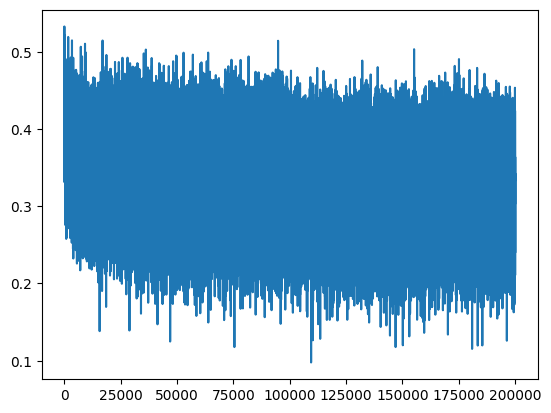

In [8]:
plt.plot(loss_i)

In [9]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)

In [10]:
bnmean, bnmean_running

(tensor([[-2.3948,  0.3696, -1.2718,  1.2949,  0.9555,  0.9955,  1.5502, -1.9208,
           1.1124,  1.2444, -1.8118, -2.7730,  0.0738, -0.6075,  0.4335, -0.6823,
           0.7747, -2.1883, -0.1999,  1.5907, -0.8760,  0.0858, -0.2508,  0.4101,
           1.0317,  1.6305,  1.1978,  0.9556,  0.3583,  1.9510, -0.0681, -1.2067,
          -0.1050, -0.2660, -0.4749, -1.4983, -2.6133,  0.0533, -0.0121,  0.6010,
          -0.2272, -0.8899, -0.2851, -0.1833,  0.6506,  0.8990,  1.5831, -0.3836,
           1.9892,  1.0677,  1.7157, -0.7880,  2.0549,  0.3595,  0.5519, -1.9214,
          -0.0325,  0.7197,  0.8938, -0.7950, -0.6654,  0.9819,  0.4983,  0.2976,
           1.1429,  1.6462, -1.3212,  2.4308, -0.5223,  0.4783, -1.0088,  0.2362,
           1.0452, -1.5624, -3.0715,  0.6018,  0.7532, -0.0513,  0.4650,  0.7593,
           0.2517,  1.2640,  1.4016,  0.5572, -0.2063, -0.0653, -1.3350,  0.5009,
           0.1291, -0.4667, -0.3977,  1.4659, -1.1291, -0.8739, -0.9940,  0.2943,
          -0.302

In [11]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)

    hpreact = embcat @ W1
    # hpreact = bngain * ((hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)) + bnbias
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674147605895996
val 2.1056840419769287


In [12]:
g = torch.Generator().manual_seed(MANUAL_SEED + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

briahgmnazzierstel.
fhal.
qetvangendra.
zasderidgmlillshi.
jedrekesslangfarremyahmilkarib.
shdumrithghnestin.
jewtdvi.
xibuscfsubferndersymusemels.
kaylahshmyah.
haz.
sadya.
sufizajahkirrentirbbisvekostep.
qwilfeyroshbh.
zprixabumushwa.
hmarishid.
qinfelvshlwaldarikthrishthzighikassmitgftrvissivishten.
riefhrriyaxabushdumichekitya.
blvardtai.
bdgihzirrlq.
saadenaysophlrystta.


### __pytorchifying code__

In [13]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)


    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [14]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(MANUAL_SEED)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("Total params: ", sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

Total params:  47024


In [15]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()


    lr = 1.0 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"Iteration {i}/{max_steps} : Loss = {loss.item():.4f}")
    loss_i.append(loss.log10().item())

    with torch.no_grad():
        ud.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i > 1000:
        break

Iteration 0/200000 : Loss = 3.2870


layer 2 (      Tanh): mean +0.02, std 0.63, saturated: 4.25%
layer 5 (      Tanh): mean -0.01, std 0.63, saturated: 3.06%
layer 8 (      Tanh): mean -0.02, std 0.64, saturated: 3.28%
layer 11 (      Tanh): mean -0.01, std 0.63, saturated: 3.09%
layer 14 (      Tanh): mean +0.02, std 0.64, saturated: 3.31%


Text(0.5, 1.0, 'activation distribution')

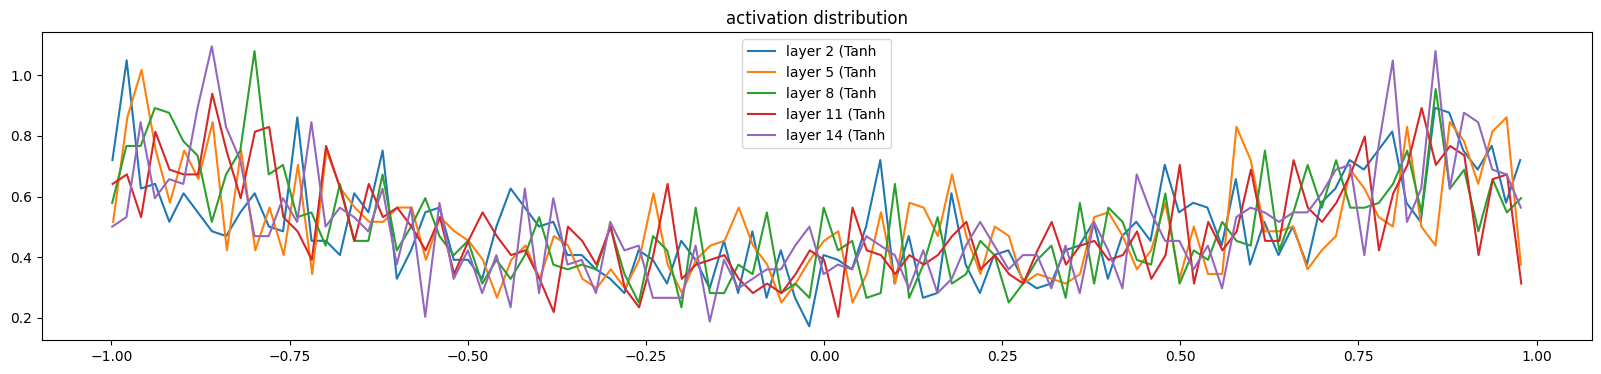

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 4.360865e-03
layer 5 (      Tanh): mean +0.000000, std 3.804867e-03
layer 8 (      Tanh): mean -0.000000, std 3.511071e-03
layer 11 (      Tanh): mean +0.000000, std 3.270141e-03
layer 14 (      Tanh): mean -0.000000, std 3.144625e-03


Text(0.5, 1.0, 'gradient distribution')

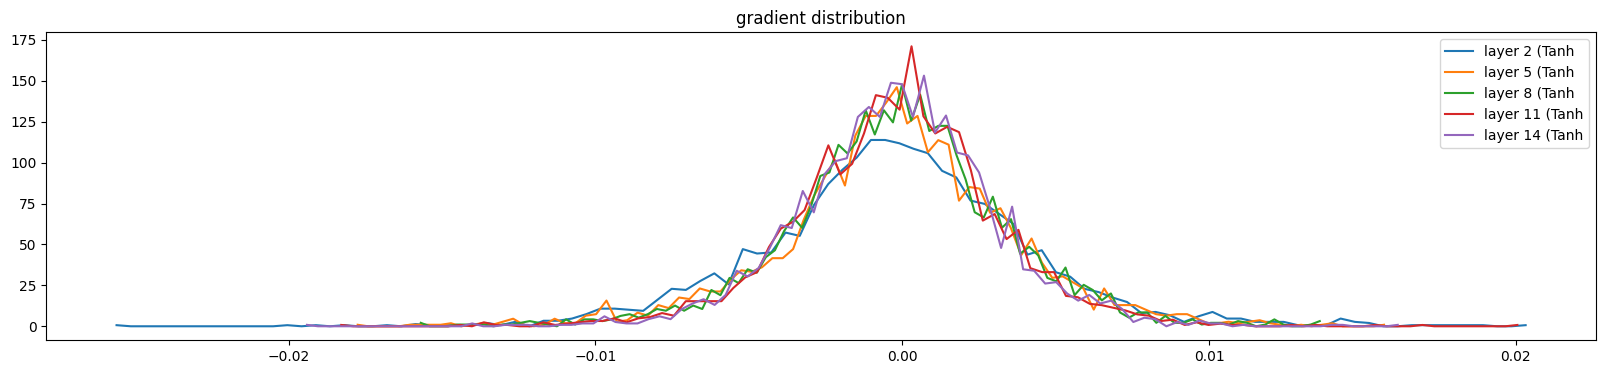

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.547103e-03 | grad:data ratio 8.283903e-03
weight  (30, 100) | mean -0.000005 | std 2.678894e-03 | grad:data ratio 2.606678e-03
weight (100, 100) | mean +0.000026 | std 1.376783e-03 | grad:data ratio 1.380236e-03
weight (100, 100) | mean +0.000004 | std 1.260896e-03 | grad:data ratio 1.251007e-03
weight (100, 100) | mean +0.000012 | std 1.097642e-03 | grad:data ratio 1.093699e-03
weight (100, 100) | mean -0.000011 | std 1.066148e-03 | grad:data ratio 1.061356e-03
weight  (100, 27) | mean -0.000035 | std 1.968947e-03 | grad:data ratio 1.988356e-03


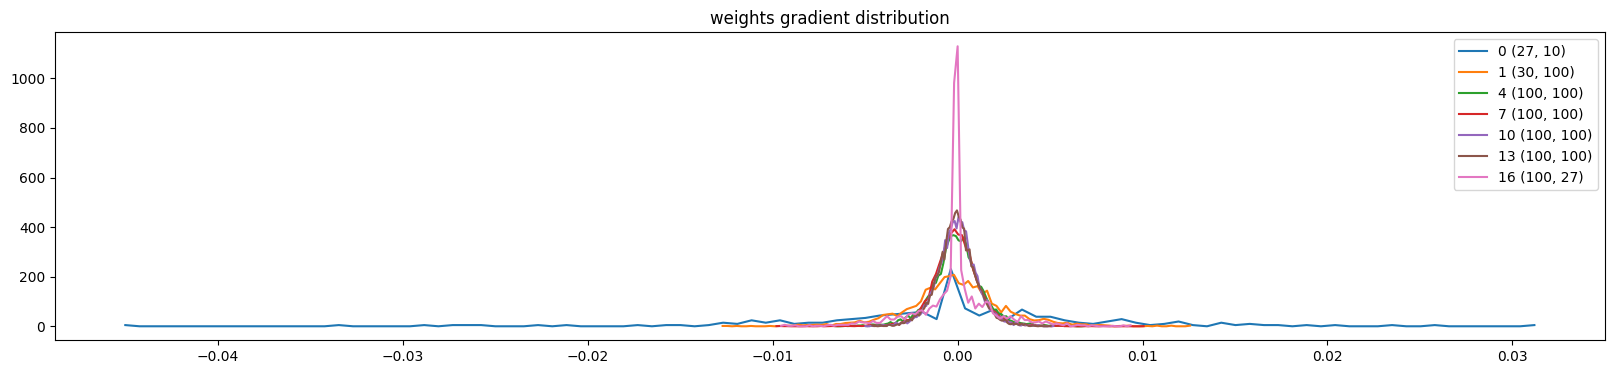

In [18]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

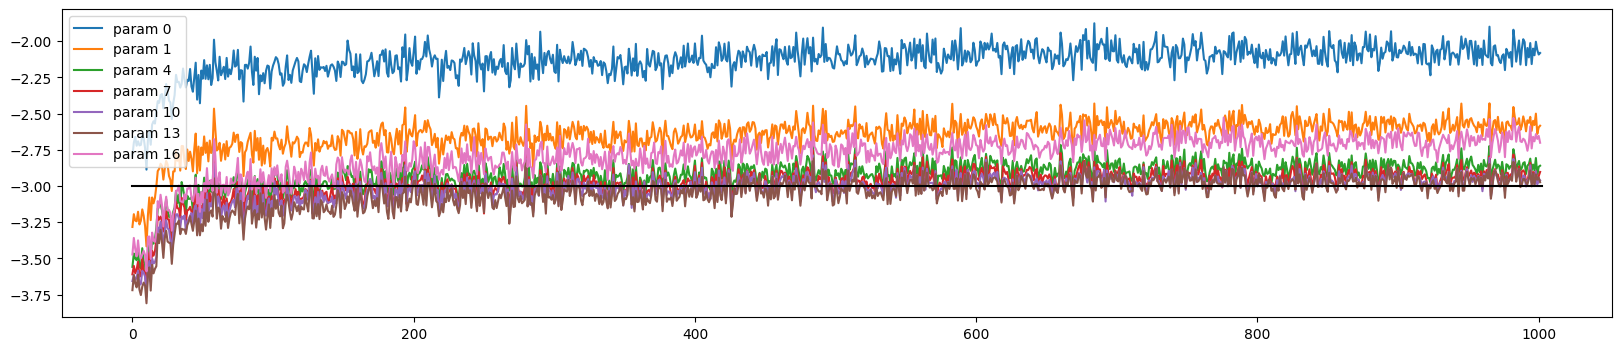

In [19]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
